<a href="https://colab.research.google.com/github/dghosh2/gdtuo-extension/blob/main/sgd_on_streiods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gradient-descent-the-ultimate-optimizer

In [ ]:
import torch
import math
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
class MNIST_FullyConnected(nn.Module):
    """
    A fully-connected NN for the MNIST task. This is Optimizable but not itself
    an optimizer.
    """
    def __init__(self, num_inp, num_hid, num_out):
        super(MNIST_FullyConnected, self).__init__()
        self.layer1 = nn.Linear(num_inp, num_hid)
        self.layer2 = nn.Linear(num_hid, num_out)

    def initialize(self):
        nn.init.kaiming_uniform_(self.layer1.weight, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.layer2.weight, a=math.sqrt(5))

    def forward(self, x):
        """Compute a prediction."""
        x = self.layer1(x)
        x = torch.tanh(x)
        x = self.layer2(x)
        x = torch.tanh(x)
        x = F.log_softmax(x, dim=1)
        return x

# BATCH_SIZE = 256
BATCH_SIZE = 256
EPOCHS = 10
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

mnist_train = torchvision.datasets.MNIST('./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
mnist_test = torchvision.datasets.MNIST('./data', train=False, download=True, transform=torchvision.transforms.ToTensor())
dl_train = torch.utils.data.DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True)
dl_test = torch.utils.data.DataLoader(mnist_test, batch_size=10000, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 119934664.48it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 78051349.11it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 37023567.81it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 9430954.84it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# SDGM
# class for ultimate optimizer
class Optimizable:
    def __init__(self, parameters, optimizer):
        self.parameters = parameters # a dict mapping names to tensors
        self.optimizer = optimizer   # which must itself be Optimizable!
        self.all_params_with_gradients = []

    def initialize(self):
        ''' Initialize parameters, e.g. with a Kaiming initializer. '''
        pass

    def begin(self):
        ''' Enable gradient tracking on current parameters. '''
        for param in self.all_params_with_gradients:
             param.grad = None
        self.all_params_with_gradients.clear()
        for name, param in self.parameters.items():
            param.requires_grad_() # keep gradient information...
            param.retain_grad()    # even if not a leaf...
            self.all_params_with_gradients.append(param)
        self.optimizer.begin()

    def zero_grad(self):
        ''' Set all gradients to zero. '''
        for param in self.all_params_with_gradients:
            param.grad = torch.zeros_like(param)
        self.optimizer.zero_grad()

    ''' Note: at this point you would probably call .backwards() on the loss
    function. '''

    def step(self):
        ''' Update parameters '''
        pass

class NoOpOptimizer(Optimizable):
    '''
    NoOpOptimizer sits on top of a stack, and does not affect what lies below.
    '''
    def __init__(self):
        pass

    def initialize(self):
        pass

    def begin(self):
        pass

    def zero_grad(self):
        pass

    def step(self, params):
        pass

    def __str__(self):
        return ''

class SGD_ON_STREIODS(Optimizable):
    '''
    A hyperoptimizable SGD.
    '''
    def __init__(self, alpha=0.01, mu=0.0, wd=0.0, dp=0.0, optimizer=NoOpOptimizer()):
        self.mu = mu
        self.state = {}
        parameters = {
            'alpha': torch.tensor(alpha),
            'mu': torch.tensor(mu),
            'wd': torch.tensor(wd),
            'dp': torch.tensor(dp)
        }
        super().__init__(parameters, optimizer)

    def step(self, params):
        self.optimizer.step(self.parameters)
        for name, param in params.items():
            g = param.grad.detach()
            p = param.detach()
            if self.mu != 0.0:
                if name not in self.state:
                    buf = self.state[name] = g
                else:
                    buf = self.state[name].detach()
                    buf = buf * self.parameters['mu'] + g
                g = self.state[name] = buf
            # Apply weight decay
            if self.parameters['wd'] != 0.0:
                g.add_(p, alpha=self.parameters['wd'].item())
            # Apply dampening
            if self.parameters['dp'] != 0.0:
                g.mul_(1 - self.parameters['dp'])
            params[name] = p - g * self.parameters['alpha']

    def __str__(self):
        return 'sgd / '+ str(self.optimizer)

In [ ]:
import time
model = MNIST_FullyConnected(28 * 28, 128, 10).to(DEVICE)
BATCH_SIZE=50
EPOCH=10
optimizers = [
    torch.optim.SGD(model.parameters(), lr=0.01),
    # torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9),  # You can add momentum here if needed
    # torch.optim.Adam(model.parameters(), lr=0.001)
]

optimizer_labels=[
    "SGD(lr=0.01)",
    # "SGD(lr=0.01, momentum=0.9)",
    # "Adam(lr=0.001)"
]

losses = [[] for _ in optimizers]  # Store losses for each optimizer
training_times = [0.0] * len(optimizers)
accuracies = [[] for _ in optimizers]  # Store accuracies for each optimizer

for idx, optimizer in enumerate(optimizers):
    start_time = time.time()
    for i in range(1, EPOCHS + 1):
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        for j, (features_, labels_) in enumerate(dl_train):
            features, labels = torch.reshape(features_, (-1, 28 * 28)).to(DEVICE), labels_.to(DEVICE)
            pred = model(features)
            loss = F.nll_loss(pred, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * features_.size(0)
            _, predicted = torch.max(pred, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

        train_loss = running_loss / len(dl_train.dataset)
        losses[idx].append(train_loss)
        accuracy = correct_predictions / total_samples
        accuracies[idx].append(accuracy)
        if i == EPOCHS:
          print("EPOCH: {}, TRAIN LOSS: {:.4f}, optimizer: {}".format(i, train_loss, optimizer_labels[idx]))
    end_time = time.time()
    training_times[idx] = end_time - start_time
    print("Optimizer: {}, Training Time: {:.2f} seconds".format(str(optimizer), training_times[idx]))

# # Plot training losses
# for idx, optimizer_label in enumerate(optimizer_labels):
#     plt.plot(range(1, EPOCHS + 1), losses[idx], label=optimizer_label)

# plt.xlabel("Epoch")
# plt.ylabel("Training Loss")
# plt.title("Training Loss for Different Optimizers")
# plt.legend()
# plt.show()
sgd_loss = losses[0]
sgd_time = training_times[0]
sgd_acc = accuracies[0]

EPOCH: 10, TRAIN LOSS: 1.1500, optimizer: SGD(lr=0.01)
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
), Training Time: 71.82 seconds


In [ ]:
from gradient_descent_the_ultimate_optimizer import gdtuo
import time

EPOCHS=10
optimizers = [
    gdtuo.SGD(),
    gdtuo.SGD(optimizer=gdtuo.SGD(0.01)),
    # gdtuo.SGD(optimizer=gdtuo.Adam(0.1)),
    # gdtuo.Adam(),
    gdtuo.Adam(optimizer=gdtuo.Adam()),
    gdtuo.Adam(optimizer=gdtuo.SGD(1e-5)),
    # SGD_ON_STREIODS(),
    SGD_ON_STREIODS(alpha=0.01, mu=0.9, wd=0.0001, dp=0.000001, optimizer=gdtuo.SGD(0.01))
]

optimizer_labels=[
    "SGD(lr=0.01)" # Extra
    "gdtuo.SGD()",
    "gdtuo.SGD(optimizer=gdtuo.SGD(0.01))",
    # "gdtuo.SGD(optimizer=gdtuo.Adam(0.1))", #no
    # "gdtuo.Adam()", #NO
    "gdtuo.Adam(optimizer=gdtuo.Adam())",
    "gdtuo.Adam(optimizer=gdtuo.SGD(1e-5))"
    # "SGD_ON_STREIODS()", #no
    "SGD_ON_STREIODS(optimizer=gdtuo.SGD(0.01))"
]

losses = [[] for _ in optimizers]  # Store losses for each optimizer
training_times = [0.0] * len(optimizers)
accuracies = [[] for _ in optimizers]  # Store accuracies for each optimizer


for idx, optimizer in enumerate(optimizers):
    model = MNIST_FullyConnected(28 * 28, 128, 10).to(DEVICE)
    mw = gdtuo.ModuleWrapper(model, optimizer=optimizer)
    mw.initialize()
    start_time = time.time()

    for i in range(1, EPOCHS + 1):
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        for j, (features_, labels_) in enumerate(dl_train):
            mw.begin()
            features, labels = torch.reshape(features_, (-1, 28 * 28)).to(DEVICE), labels_.to(DEVICE)
            pred = mw.forward(features)
            loss = F.nll_loss(pred, labels)
            mw.zero_grad()
            loss.backward(create_graph=True)
            mw.step()
            running_loss += loss.item() * features_.size(0)

            _, predicted = torch.max(pred, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

        train_loss = running_loss / len(dl_train.dataset)
        losses[idx].append(train_loss)
        accuracy = correct_predictions / total_samples
        accuracies[idx].append(accuracy)
        # if i == EPOCHS:
        print("EPOCH: {}, TRAIN LOSS: {:.4f}, optimizer: {}".format(i, train_loss, str(optimizer)))
    end_time = time.time()
    training_times[idx] = end_time - start_time
    print("Optimizer: {}, Training Time: {:.2f} seconds".format(str(optimizer), training_times[idx]))

losses.insert(0, sgd_loss)
training_times.insert(0, sgd_time)
accuracies.insert(0, sgd_acc)

EPOCH: 1, TRAIN LOSS: 1.9733, optimizer: sgd / 
EPOCH: 2, TRAIN LOSS: 1.5918, optimizer: sgd / 
EPOCH: 3, TRAIN LOSS: 1.4295, optimizer: sgd / 
EPOCH: 4, TRAIN LOSS: 1.3408, optimizer: sgd / 
EPOCH: 5, TRAIN LOSS: 1.2835, optimizer: sgd / 
EPOCH: 6, TRAIN LOSS: 1.2425, optimizer: sgd / 
EPOCH: 7, TRAIN LOSS: 1.2113, optimizer: sgd / 
EPOCH: 8, TRAIN LOSS: 1.1865, optimizer: sgd / 
EPOCH: 9, TRAIN LOSS: 1.1662, optimizer: sgd / 
EPOCH: 10, TRAIN LOSS: 1.1492, optimizer: sgd / 
Optimizer: sgd / , Training Time: 68.71 seconds
EPOCH: 1, TRAIN LOSS: 1.3770, optimizer: sgd / sgd / 
EPOCH: 2, TRAIN LOSS: 1.0675, optimizer: sgd / sgd / 
EPOCH: 3, TRAIN LOSS: 1.0219, optimizer: sgd / sgd / 
EPOCH: 4, TRAIN LOSS: 0.9990, optimizer: sgd / sgd / 
EPOCH: 5, TRAIN LOSS: 0.9837, optimizer: sgd / sgd / 
EPOCH: 6, TRAIN LOSS: 0.9722, optimizer: sgd / sgd / 
EPOCH: 7, TRAIN LOSS: 0.9631, optimizer: sgd / sgd / 
EPOCH: 8, TRAIN LOSS: 0.9554, optimizer: sgd / sgd / 
EPOCH: 9, TRAIN LOSS: 0.9487, optimizer

In [ ]:
# optimizer_labels.insert(0, "SGD")

SGD(lr=0.01)gdtuo.SGD()
gdtuo.SGD(optimizer=gdtuo.SGD(0.01))
gdtuo.Adam(optimizer=gdtuo.Adam())
gdtuo.Adam(optimizer=gdtuo.SGD(1e-5))SGD_ON_STREIODS(optimizer=gdtuo.SGD(0.01))


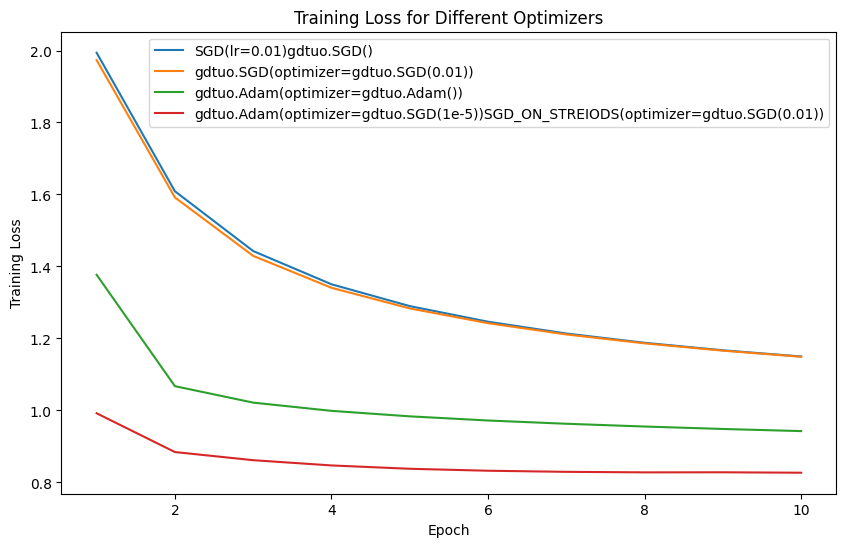

In [ ]:
plt.figure(figsize=(10,6))
# Plot training losses
for idx, optimizer in enumerate(optimizer_labels):
    plt.plot(range(1, EPOCHS + 1), losses[idx], label=str(optimizer))
    print(optimizer)

plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss for Different Optimizers")
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.legend()
plt.show()

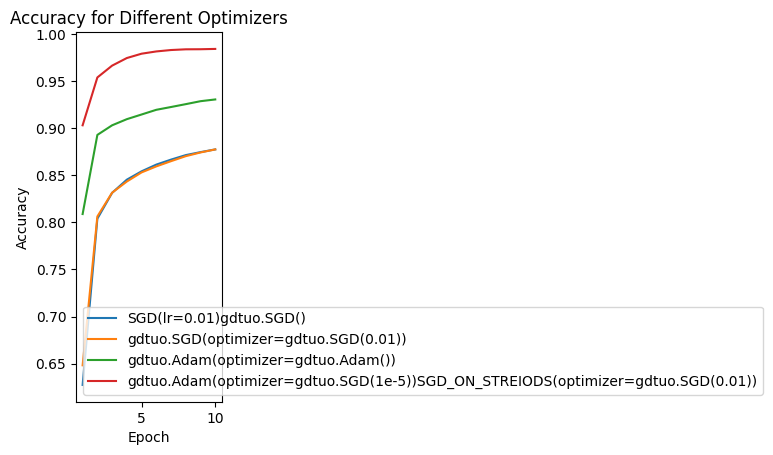

In [ ]:
# Plot accuracies
plt.subplot(1, 3, 2)
for idx, optimizer in enumerate(optimizer_labels):
    plt.plot(range(1, EPOCHS + 1), accuracies[idx], label=str(optimizer))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy for Different Optimizers")
plt.legend()